In [1]:
import os
import pandas as pd
import re
import os
import numpy as np
import pandas as pd
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, SubsetRandomSampler, Subset
from torch import Tensor
from glob import glob
from PIL import Image
from matplotlib import pyplot as plt
from typing import Optional
from skimage import img_as_float
from tqdm import tqdm
import xml.etree.ElementTree as ET
import seaborn as sns
import timm

c:\Users\amana\anaconda3\envs\DT\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# root
data_root = 'C:/Users/amana/Downloads/BreaKHis_v1/histology_slides/breast'

records = []

# b / m
for tumor_type in ["benign", "malignant"]:
    tumor_dir = os.path.join(data_root, tumor_type)
    if not os.path.exists(tumor_dir):
        continue

    # under SOB folder
    sob_dir = os.path.join(tumor_dir, "SOB")
    if not os.path.exists(sob_dir):
        continue

    # Traverse subtype(eg ductal_carcinoma, tubular_adenoma)
    for subtype in os.listdir(sob_dir):
        subtype_dir = os.path.join(sob_dir, subtype)
        if not os.path.isdir(subtype_dir):
            continue

        # Traverse subject (eg SOB_M_DC-14-10926)
        for subject_folder in os.listdir(subtype_dir):
            subject_dir = os.path.join(subtype_dir, subject_folder)
            if not os.path.isdir(subject_dir):
                continue

            # extract subject_id  → "<YEAR>-<SLIDE_ID>"
            m = re.search(r'(?P<year>\d{2})[-_](?P<slide>\d+[A-Z]{0,3})$', subject_folder)
            subject_id = f"{m.group('year')}-{m.group('slide')}" if m else subject_folder

            # Traverse magnification(40X, 100X, 200X, 400X)
            for mag_folder in os.listdir(subject_dir):
                mag_dir = os.path.join(subject_dir, mag_folder)
                if not os.path.isdir(mag_dir):
                    continue

                # extract magnification
                try:
                    magnification = int(''.join(filter(str.isdigit, mag_folder)))
                except:
                    magnification = None

                # Traverse image file
                for fname in os.listdir(mag_dir):
                    if not fname.lower().endswith(".png"):
                        continue

                    fpath = os.path.join(mag_dir, fname)

                    # extract tumor_type (b/m)
                    # e.g., SOB_M_DC-14-10926-100-001.png
                    name_parts = fname.split('_')
                    tumor_flag = name_parts[1].lower() if len(name_parts) > 1 else tumor_type[0]

                    # subtype abbreviation
                    subtype_abbr = name_parts[2].split('-')[0].lower() if len(name_parts) > 2 else subtype.lower()

                    # verify magnification
                    mag_in_name = None
                    if '-' in fname:
                        segs = fname.split('-')
                        for s in segs:
                            if s.isdigit() and s in ["40", "100", "200", "400"]:
                                mag_in_name = int(s)
                                break
                    magnification = mag_in_name or magnification

                    records.append({
                        "filepath": fpath,
                        "tumor_type": tumor_flag,  # 'b' or 'm'
                        "subtype": subtype_abbr,   # e.g., 'dc'
                        "magnification": magnification,
                        "subject_id": subject_id
                    })

# save CSV
df = pd.DataFrame(records)
save_path = os.path.join(data_root, "BreaKHis_metadata.csv")
df.to_csv(save_path, index=False)

print(f"✅ Metadata CSV saved to: {save_path}")

✅ Metadata CSV saved to: C:/Users/amana/Downloads/BreaKHis_v1/histology_slides/breast\BreaKHis_metadata.csv


In [3]:
random.seed(42)

path = 'C:/Users/amana/Downloads/BreaKHis_v1/histology_slides/breast/BreaKHis_metadata.csv'
data = pd.read_csv(path)

unique_subjects = data["subject_id"].unique().tolist()
random.shuffle(unique_subjects)

n = len(unique_subjects)
n_train = int(0.8 * n)
#n_val = int(0.2 * n)
train_subjects = unique_subjects[:n_train]
val_subjects = unique_subjects[n_train:] #n_train+n_val
#test_subjects = unique_subjects[n_train+n_val:]

def assign_partition(row):
    sid = row["subject_id"]
    if sid in train_subjects:
        return "train"
    elif sid in val_subjects:
        return "val"
    #else:
        #return "test"

data["partition"] = data.apply(assign_partition, axis=1)

output_path = 'C:/Users/amana/Downloads/BreaKHis_v1/histology_slides/breast/BreaKHis_metadata_split.csv'
data.to_csv(output_path, index=False)

print("✅ Split done.")

✅ Split done.


In [4]:
METADATA_PATH = 'C:/Users/amana/Downloads/BreaKHis_v1/histology_slides/breast/BreaKHis_metadata_split.csv'
NUM_CLASSES = 2  # Benign (0) and Malignant (1)
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
NUM_EPOCHS = 5

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


Using device: cpu


In [5]:
class BreaKHisDataset(Dataset):
    """
    A custom PyTorch Dataset for loading BreaKHis images.
    Labels: 'b' -> 0 (Benign), 'm' -> 1 (Malignant)
    """
    def __init__(self, metadata_df: pd.DataFrame, transform=None):
        """
        Args:
            metadata_df: DataFrame containing 'filepath', 'tumor_type', and 'partition'.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.metadata = metadata_df
        self.transform = transform
        self.label_map = {'b': 0, 'm': 1} # Map 'b' to 0 and 'm' to 1

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Load image (ensuring it's in RGB format)
        img_path = self.metadata.iloc[idx]['filepath']
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            # Handle broken files if any
            print(f"Could not open image {img_path}: {e}")
            return None, None 

        # Get label and map to integer
        raw_label = self.metadata.iloc[idx]['tumor_type']
        label = self.label_map.get(raw_label, -1)
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
            
        return image, torch.tensor(label, dtype=torch.long)

# Helper function to remove corrupt samples from DataLoader
def collate_fn(batch):
    # Filter out None values returned by __getitem__ (e.g., failed image loads)
    batch = [item for item in batch if item[0] is not None]
    if not batch:
        return None, None
    return torch.utils.data.dataloader.default_collate(batch)

In [6]:
# --- 3. Transformations and DataLoaders ---
from torchvision import transforms

# --- 3. Transformations and DataLoaders ---

# Helper function to define the image augmentations
def get_transforms(img_size=224):
    """Defines the standard image transformations."""
    train_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform


def create_dataloaders(df, train_transform, val_transform):
    """Splits the metadata and creates the DataLoaders with num_workers=0."""
    # Split the DataFrame based on the 'partition' column
    train_df = df[df['partition'] == 'train'].reset_index(drop=True)
    val_df = df[df['partition'] == 'val'].reset_index(drop=True)

    # Create datasets
    train_dataset = BreaKHisDataset(train_df, transform=train_transform)
    val_dataset = BreaKHisDataset(val_df, transform=val_transform)

    # Create DataLoaders
    # CRITICAL FIX: Set num_workers=0 for stability on Windows systems.
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=collate_fn)
    
    print(f"Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")
    
    return train_loader, val_loader

# --- Load the Data (defining metadata_df) ---
try:
    # This line defines the missing variable 'metadata_df'
    metadata_df = pd.read_csv(METADATA_PATH) 
except FileNotFoundError:
    print(f"ERROR: Metadata file not found at {METADATA_PATH}. Please verify the path.")
    # Stop execution if the file is missing

# Initialize transformations and DataLoaders
train_transform, val_transform = get_transforms()
train_loader, val_loader = create_dataloaders(metadata_df, train_transform, val_transform)

Train samples: 6014, Validation samples: 1895


In [7]:
def load_swin_transformer(num_classes):
    """
    Loads a pre-trained Swin Transformer from the timm library and adapts it 
    for the binary classification task.
    
    We are using a Swin Transformer Tiny (swin_tiny_patch4_window7_224).
    """
    # `timm` automatically adjusts the final layer for `num_classes`
    model = timm.create_model(
        'swin_tiny_patch4_window7_224', 
        pretrained=True, 
        num_classes=num_classes
    )
    
    print(f"✅ Loaded Swin Transformer ('swin_tiny_patch4_window7_224') pre-trained on ImageNet.")
    
    # Move model to GPU if available
    return model.to(DEVICE)

# Load the model
model = load_swin_transformer(NUM_CLASSES)

# Initialize Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"Loss Function: {criterion}")
print(f"Optimizer: {optimizer}")

✅ Loaded Swin Transformer ('swin_tiny_patch4_window7_224') pre-trained on ImageNet.
Loss Function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)


In [ ]:
def train_model(train_loader, val_loader, model, criterion, optimizer):
    """Main function to train and validate the model."""
    
    best_val_accuracy = 0.0
    
    for epoch in range(NUM_EPOCHS):
        # Training Phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} (Training) ---")
        # Use tqdm to show a progress bar
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1} Train", leave=False)
        
        for images, labels in train_pbar:
            # Skip batch if collate_fn returned None (i.e., batch was empty)
            if images is None:
                continue
                
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
            train_pbar.set_postfix({'Loss': f'{loss.item():.4f}'})

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        print(f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

        # Validation Phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        print(f"--- Epoch {epoch+1}/{NUM_EPOCHS} (Validation) ---")
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1} Val", leave=False)
        
        with torch.no_grad():
            for images, labels in val_pbar:
                # Skip batch if collate_fn returned None
                if images is None:
                    continue
                    
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                
                val_pbar.set_postfix({'Loss': f'{loss.item():.4f}'})

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
        
        # Save the best model based on validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_swin_model.pth')
            print("Model saved to 'best_swin_model.pth' based on improved validation accuracy.")
        
    print("\nTraining complete.")

# Start the training process
train_model(train_loader, val_loader, model, criterion, optimizer)


--- Epoch 1/5 (Training) ---


Epoch 1 Train:   1%|▏         | 5/376 [00:28<32:54,  5.32s/it, Loss=0.0160]

In [9]:
# --- Next Step: Comprehensive Evaluation ---
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from torchvision import transforms # Import transforms for plotting normalization

# Re-run the function definition from earlier for consistency
def load_swin_transformer(num_classes):
    import timm
    model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=num_classes)
    return model

# 1. Load the Best Model
best_model = load_swin_transformer(NUM_CLASSES)
try:
    best_model.load_state_dict(torch.load('best_swin_model.pth'))
    best_model.to(DEVICE)
    best_model.eval() # Set to evaluation mode
    print("✅ Successfully loaded the best model weights.")
except FileNotFoundError:
    print("ERROR: 'best_swin_model.pth' not found.")
    # Stop here if the model file is missing

✅ Successfully loaded the best model weights.


Evaluating Validation Set: 100%|██████████| 119/119 [05:44<00:00,  2.89s/it]



--- Classification Report for Validation Set ---
               precision    recall  f1-score   support

   Benign (0)       0.92      0.67      0.77       749
Malignant (1)       0.82      0.96      0.88      1146

     accuracy                           0.84      1895
    macro avg       0.87      0.81      0.83      1895
 weighted avg       0.86      0.84      0.84      1895



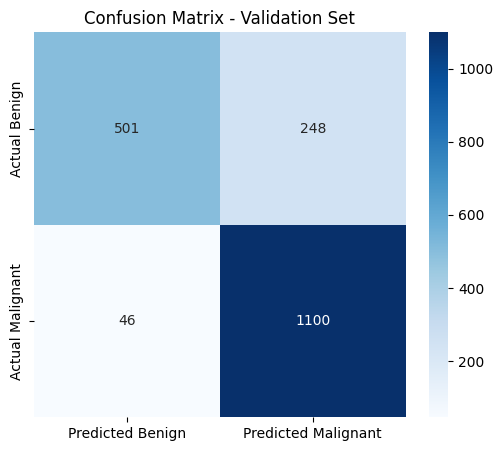


ROC AUC Score for Validation Set: 0.8325


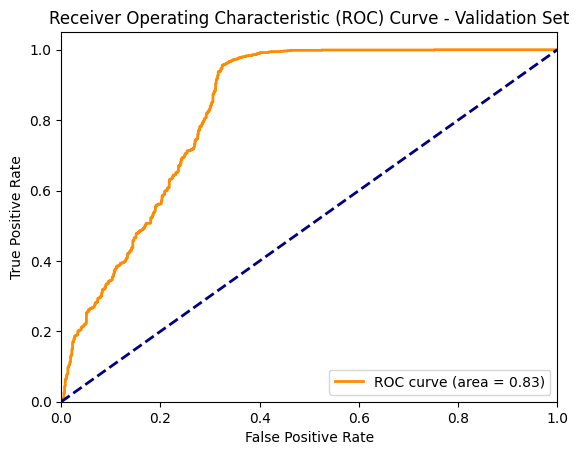

In [11]:
def evaluate_model(model, data_loader, set_name):
    """Calculates all key metrics for a given data loader."""
    all_labels = []
    all_predictions = []
    all_probabilities = []
    
    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc=f"Evaluating {set_name}"):
            if images is None:
                continue
                
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            # Probability of Malignant (class 1)
            probabilities = F.softmax(outputs, dim=1)[:, 1] 
            _, predicted = torch.max(outputs.data, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    # 1. Classification Report (Precision, Recall, F1)
    print(f"\n--- Classification Report for {set_name} ---")
    print(classification_report(all_labels, all_predictions, target_names=['Benign (0)', 'Malignant (1)']))

    # 2. Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted Benign', 'Predicted Malignant'], 
                yticklabels=['Actual Benign', 'Actual Malignant'])
    plt.title(f'Confusion Matrix - {set_name}')
    plt.show()

    # 3. ROC AUC Score
    roc_auc = roc_auc_score(all_labels, all_probabilities)
    print(f"\nROC AUC Score for {set_name}: {roc_auc:.4f}")

    # 4. Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_probabilities)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve - {set_name}')
    plt.legend(loc="lower right")
    plt.show()

    return cm, roc_auc, fpr, tpr

# Run evaluation on Validation Data and capture the returned variables
conf_matrix, auc_score, fpr_list, tpr_list = evaluate_model(best_model, val_loader, "Validation Set")


--- PATIENT-LEVEL (MAJORITY VOTE) EVALUATION ---
Total Patients in Validation Set: 17

--- Patient-Level Classification Report ---
                       precision    recall  f1-score   support

   Benign Patient (0)       1.00      0.83      0.91         6
Malignant Patient (1)       0.92      1.00      0.96        11

             accuracy                           0.94        17
            macro avg       0.96      0.92      0.93        17
         weighted avg       0.95      0.94      0.94        17



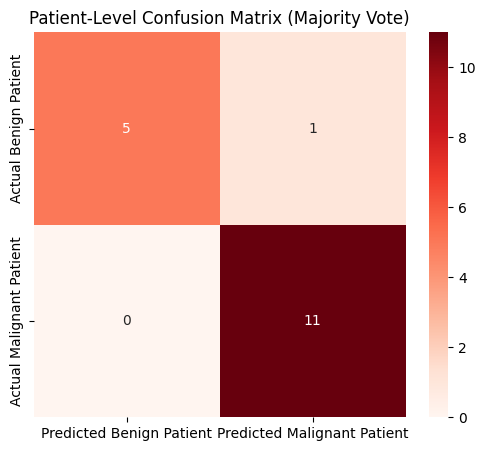


Final Patient-Level Accuracy: 94.12%


In [12]:
#patient level anaylsis
# --- Patient-Level Analysis Block ---
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# NOTE: METADATA_PATH, NUM_CLASSES, DEVICE, and best_model must be defined
# We'll re-load the metadata to ensure we have the 'subject_id' column

# 1. Collect all predictions and metadata from the Validation Set
def collect_predictions_with_metadata(model, data_loader, metadata_df):
    """
    Collects predictions, true labels, and associated metadata (like subject_id)
    from the DataLoader for the validation set.
    """
    # Filter the metadata to only include validation subjects
    val_metadata_df = metadata_df[metadata_df['partition'] == 'val'].reset_index(drop=True)
    
    # Map index from DataLoader back to the correct row in the validation DataFrame
    index_map = {i: val_metadata_df.iloc[i]['subject_id'] for i in range(len(val_metadata_df))}

    all_predictions = []
    all_true_labels = []
    all_subject_ids = []
    
    model.eval()
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(tqdm(data_loader, desc="Collecting Patient Data")):
            if images is None:
                continue
                
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            # Get the starting index of the batch in the original dataset
            start_idx = batch_idx * data_loader.batch_size
            
            for i in range(len(labels)):
                data_index = start_idx + i
                
                # Retrieve subject ID using the index map
                if data_index in index_map:
                    all_subject_ids.append(index_map[data_index])
                    all_true_labels.append(labels[i].item())
                    all_predictions.append(predicted[i].item())

    # Create a DataFrame for easy grouping
    results_df = pd.DataFrame({
        'subject_id': all_subject_ids,
        'true_label': all_true_labels,
        'image_prediction': all_predictions
    })
    
    # Drop duplicates in true_label per subject (all images from one patient must share the same true label)
    patient_true_labels = results_df.drop_duplicates(subset=['subject_id'], keep='first')[['subject_id', 'true_label']]
    
    return results_df, patient_true_labels

# Load the full metadata CSV again (assuming METADATA_PATH is defined)
try:
    metadata_df = pd.read_csv(METADATA_PATH) 
except NameError:
    # Fallback if METADATA_PATH isn't defined in the notebook context
    print("ERROR: METADATA_PATH not defined. Please define it as in Block 4.")
    # Exit or raise error
    
results_df, patient_true_labels_df = collect_predictions_with_metadata(best_model, val_loader, metadata_df)

# 2. Apply Majority Voting to Patient Predictions
patient_predictions = results_df.groupby('subject_id')['image_prediction'].agg(lambda x: x.sum() / len(x)).reset_index()
patient_predictions.rename(columns={'image_prediction': 'malignant_vote_percentage'}, inplace=True)

# Apply majority rule: > 50% of images predicted Malignant (1) makes the patient Malignant (1)
# Note: For binary classification, mean > 0.5 is equivalent to majority voting.
patient_predictions['patient_prediction'] = (patient_predictions['malignant_vote_percentage'] > 0.5).astype(int)

# 3. Merge True Labels and Predictions
final_patient_results = patient_true_labels_df.merge(patient_predictions, on='subject_id')

# Extract final patient-level labels and predictions
patient_true = final_patient_results['true_label'].values
patient_pred = final_patient_results['patient_prediction'].values

# 4. Calculate and Display Patient-Level Metrics
print("\n" + "="*50)
print("--- PATIENT-LEVEL (MAJORITY VOTE) EVALUATION ---")
print(f"Total Patients in Validation Set: {len(final_patient_results)}")
print("="*50)

# Patient-Level Classification Report
print("\n--- Patient-Level Classification Report ---")
print(classification_report(patient_true, patient_pred, target_names=['Benign Patient (0)', 'Malignant Patient (1)']))

# Patient-Level Confusion Matrix
patient_cm = confusion_matrix(patient_true, patient_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(patient_cm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['Predicted Benign Patient', 'Predicted Malignant Patient'], 
            yticklabels=['Actual Benign Patient', 'Actual Malignant Patient'])
plt.title('Patient-Level Confusion Matrix (Majority Vote)')
plt.show()

patient_accuracy = np.sum(patient_true == patient_pred) / len(patient_true)
print(f"\nFinal Patient-Level Accuracy: {patient_accuracy * 100:.2f}%")